# Elo Merchant Category Recommendation - Effect of target outliers on RMSE <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [60]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df = pd.read_csv("input/train.csv")
df = reduce_mem_usage(df)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)


We want to check how the proportion of correctly predicted target outliers (aprox -33.21) affects the RMSE. In order to decide if it is worth it to train some kind of churn model. The rest of the target values are merely predicted as the mean value of all the normal targets.

In [65]:
n = df.shape[0]
prop = np.linspace(0.5, 1, 6)
RMSE = [0]*len(prop)

# Compute the mean of the normal scores
target_mean = df[df['target']>-33]['target'].mean()   
print("Mean without outliers: {:}".format(target_mean))

Mean without outliers: -0.0


In [66]:
df_out = df[df['target']<-33]['target']
out = df_out.values[0]
n_out = df_out.shape[0]
targets = np.concatenate((df_out.values, df[df['target']>-33]['target'].values))

for i in range(len(prop)):
    n_ok = int(round(prop[i]*n_out))
    pred = [out]*n_ok + [0]*(n-n_ok)
    RMSE[i] = mean_squared_error(targets, pred) #math.sqrt(((pred-targets)**2).mean())

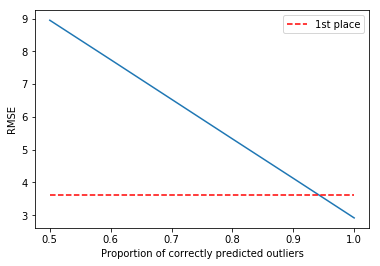

In [76]:
plt.plot(prop, RMSE)
plt.xlabel("Proportion of correctly predicted outliers")
plt.plot(prop, [3.61]*len(prop), 'r--', label="1st place")
plt.ylabel("RMSE")
plt.legend(loc='upper right')